# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [17]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### 2. Visualize the First 24 Training Images

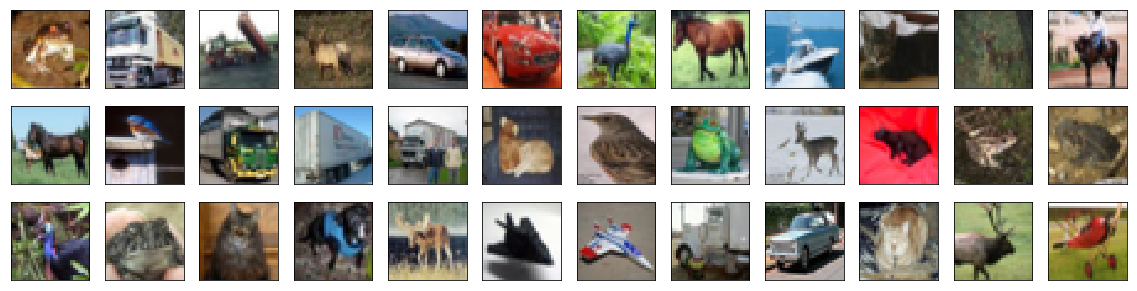

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [18]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [19]:
from keras.utils import np_utils

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Create and Configure Augmented Image Generator

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    zca_whitening=True,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    zca_whitening=True,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

### 6. Visualize Original and Augmented Images

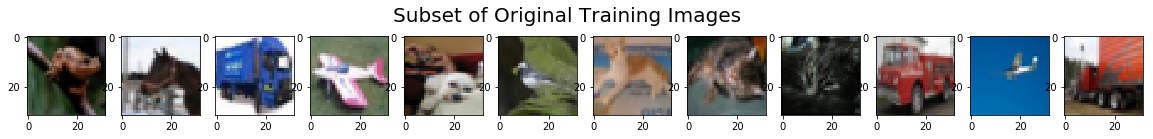

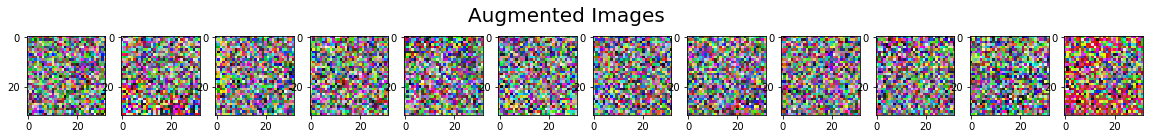

In [21]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=4))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=4))
# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=8))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 64)        832       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        16448     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 64)          16448     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 64)          16448     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 2, 64)          0         
__________

### 8. Compile the Model 

In [23]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adadelta', 
                  metrics=['accuracy'])

### 9. Train the Model 

In [ ]:
from keras.callbacks import ModelCheckpoint   

batch_size = 256
epochs = 100

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/100
Epoch 00000: val_loss improved from inf to 2.02546, saving model to aug_model.weights.best.hdf5
76s - loss: 2.2108 - acc: 0.1643 - val_loss: 2.0255 - val_acc: 0.2457
Epoch 2/100
Epoch 00001: val_loss improved from 2.02546 to 1.70569, saving model to aug_model.weights.best.hdf5
72s - loss: 1.9405 - acc: 0.2923 - val_loss: 1.7057 - val_acc: 0.4017
Epoch 3/100
Epoch 00002: val_loss improved from 1.70569 to 1.62939, saving model to aug_model.weights.best.hdf5
72s - loss: 1.7424 - acc: 0.3718 - val_loss: 1.6294 - val_acc: 0.4293
Epoch 4/100
Epoch 00003: val_loss improved from 1.62939 to 1.51419, saving model to aug_model.weights.best.hdf5
72s - loss: 1.6117 - acc: 0.4224 - val_loss: 1.5142 - val_acc: 0.4591
Epoch 5/100
Epoch 00004: val_loss did not improve
72s - loss: 1.5118 - acc: 0.4612 - val_loss: 1.5566 - val_acc: 0.4420
Epoch 6/100
Epoch 00005: val_loss improved from 1.51419 to 1.36575, saving model to aug_model.weights.best.hdf5
72s - loss: 1.4343 - acc: 0.4856 - val_loss:

### 10. Load the Model with the Best Validation Accuracy

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [11]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.6825
